In [33]:
!pip install pmdarima

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

[*********************100%***********************]  1 of 1 completed


Train size: 2635, Test size: 1130

Optimal ARIMA parameters found by auto_arima: p=0, d=1, q=1

Starting ARIMA Walk-Forward Validation...
Generating Traditional ARIMA Forecast...

Walk-Forward ARIMA Model Performance:
MAE: 1.3960
RMSE: 1.9608
MAPE: 27.7217
R²: 0.9867

Traditional ARIMA Model Performance:
MAE: 36.0388
RMSE: 39.8066
MAPE: 44.9579
R²: -4.4970


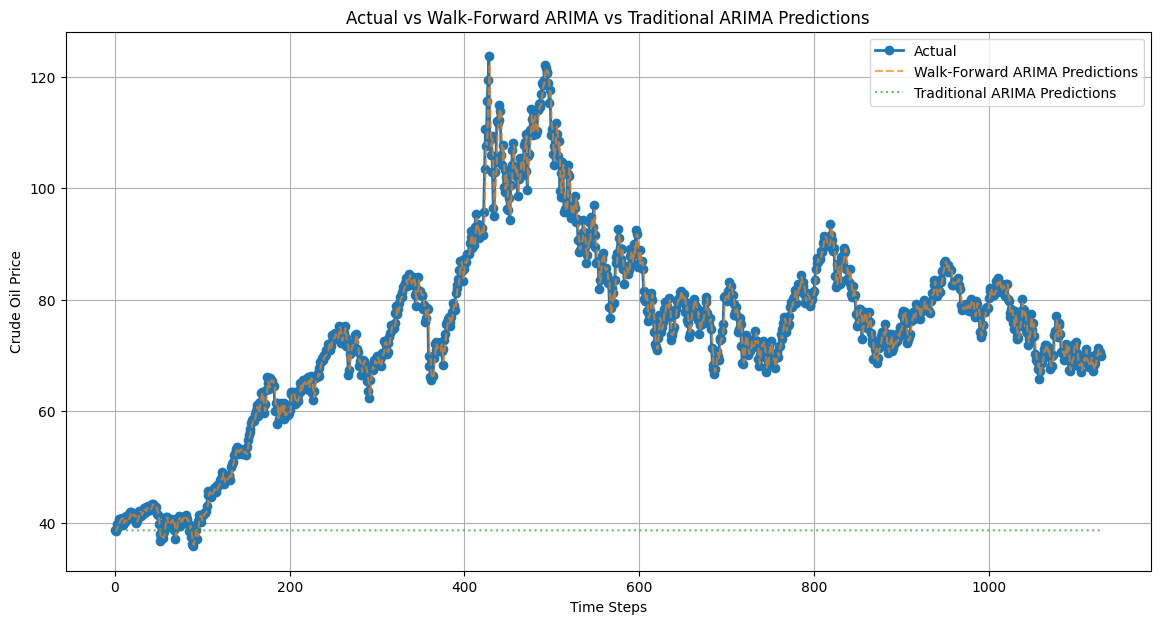

In [4]:
from pmdarima import auto_arima
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

##############################################################################
# DATA LOADING AND PREPARATION
##############################################################################
# Download the data for CL=F from Yahoo Finance starting from 2010
data = yf.download('CL=F', start='2010-01-01', end=datetime.now().strftime('%Y-%m-%d'))

# Focus on Adj Close column
data = data[['Adj Close']]

# Handle missing values with linear interpolation
data_filled = data.interpolate(method='linear', limit_direction='both')

# Extract 'Adj Close' as a NumPy array
data_values = data_filled['Adj Close'].dropna().values

# Split into training and testing sets (70% train, 30% test)
train_size = int(len(data_values) * 0.7)
train, test = data_values[:train_size], data_values[train_size:]
print(f"Train size: {len(train)}, Test size: {len(test)}")

##############################################################################
# OPTIMIZE ARIMA PARAMETERS USING AUTO_ARIMA
##############################################################################
# Fit auto_arima on the training data to find optimal (p, d, q)
arima_model_auto = auto_arima(train,
                              start_p=0, start_q=0,
                              max_p=5, max_q=5,
                              d=1,
                              seasonal=False,
                              trace=False,
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=True)

# Extract optimal parameters
p, d, q = arima_model_auto.order
arima_order = (p, d, q)
print(f"\nOptimal ARIMA parameters found by auto_arima: p={p}, d={d}, q={q}")

##############################################################################
# WALK-FORWARD VALIDATION FUNCTION
##############################################################################
def walk_forward_validation_arima(train, test, order):
    history = list(train)
    predictions = []

    for actual in test:
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(actual)

    return predictions

##############################################################################
# TRADITIONAL ARIMA FORECASTING FUNCTION
##############################################################################
def traditional_arima_forecast(train, test, order):
    model = ARIMA(train, order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test))
    return forecast

##############################################################################
# GENERATE PREDICTIONS
##############################################################################
# Walk-Forward Validation Predictions
print("\nStarting ARIMA Walk-Forward Validation...")
walk_forward_preds = walk_forward_validation_arima(train, test, arima_order)

# Traditional Forecast Predictions
print("Generating Traditional ARIMA Forecast...")
traditional_preds = traditional_arima_forecast(train, test, arima_order)

##############################################################################
# EVALUATE PERFORMANCE
##############################################################################
def evaluate_predictions(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / (actual + 1e-8))) * 100
    r2 = r2_score(actual, predicted)
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'R²': r2}

# Evaluate Walk-Forward Predictions
walk_forward_metrics = evaluate_predictions(test, walk_forward_preds)
print("\nWalk-Forward ARIMA Model Performance:")
for metric, value in walk_forward_metrics.items():
    print(f"{metric}: {value:.4f}")

# Evaluate Traditional Predictions
traditional_metrics = evaluate_predictions(test, traditional_preds)
print("\nTraditional ARIMA Model Performance:")
for metric, value in traditional_metrics.items():
    print(f"{metric}: {value:.4f}")

##############################################################################
# PLOT ACTUAL VS PREDICTED VALUES
##############################################################################
plt.figure(figsize=(14, 7))
plt.plot(range(len(test)), test, label='Actual', marker='o', linewidth=2)
plt.plot(range(len(test)), walk_forward_preds, label='Walk-Forward ARIMA Predictions', linestyle='--', alpha=0.7)
plt.plot(range(len(test)), traditional_preds, label='Traditional ARIMA Predictions', linestyle=':', alpha=0.7)
plt.title('Actual vs Walk-Forward ARIMA vs Traditional ARIMA Predictions')
plt.xlabel('Time Steps')
plt.ylabel('Crude Oil Price')
plt.legend()
plt.grid(True)
plt.show()
